In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot  as plt
from matplotlib.pyplot import imshow,imread
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


,id,boneage,male,Zscore
0,1377.png,180,0,1.279181
1,1378.png,12,0,-2.800269
2,1379.png,94,0,-0.809109
3,1380.png,120,1,-0.177766
4,1381.png,82,0,-1.100498
...,...,...,...,...
12606,15605.png,50,0,-1.877537
12607,15606.png,113,0,-0.347743
12608,15608.png,55,0,-1.756124
12609,15609.png,150,1,0.550708


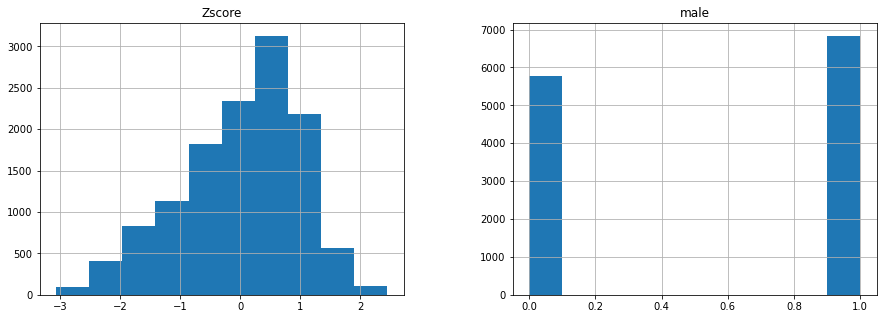

In [2]:
data_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
data_df ['id'] = data_df['id'].map(lambda x: f'{x}.png')
data_df['male']= data_df['male'].map(lambda x: 1 if (x == True) else 0)
mean = data_df['boneage'].mean()
stdd = data_df['boneage'].std()
data_df['Zscore']= data_df['boneage'].map(lambda x:(x-mean)/stdd)
data_df[['male','Zscore']].hist(figsize=(15,5))
data_df

In [3]:
test_df = pd.read_csv('../input/rsna-bone-age/boneage-test-dataset.csv')
test_df['id'] = test_df['Case ID'].map(lambda x: f'{x}.png')

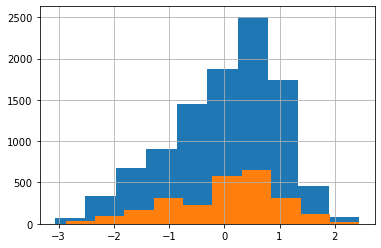

In [4]:
train_df = data_df.sample(frac=0.8)
valid_df = data_df.drop(train_df.index)


ax = [train_df['Zscore'].hist() ,valid_df['Zscore'].hist()]

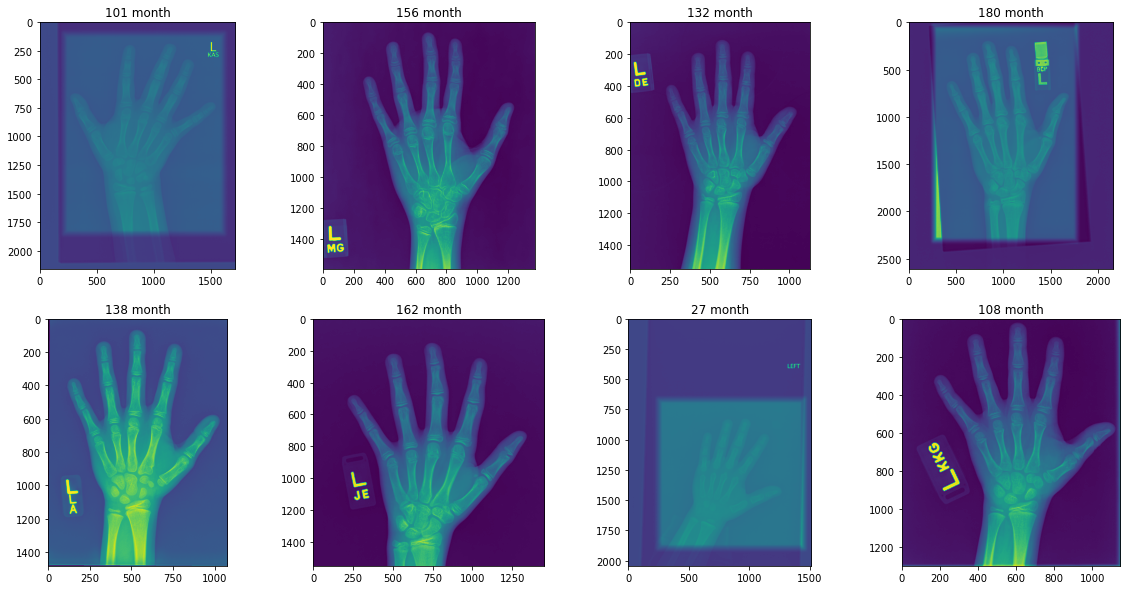

In [5]:
train_dir='../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
test_dir = '../input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'
sample = data_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['id'],sample['boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [6]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    dtype=None,
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [7]:
train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="id",
    y_col="Zscore",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 10089 validated image filenames.


In [8]:
valid_dg = core_dg.flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col="id",
    y_col="Zscore",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 2522 validated image filenames.


In [9]:
test_dg_core = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
test_dg = test_dg_core.flow_from_dataframe(test_df,
                                          x_col='id',
                                          directory = test_dir,
                                          class_mode = None)

Found 200 validated image filenames.


In [10]:
from keras import Sequential
from keras.layers import Dense,GlobalMaxPooling2D
from keras.applications.xception import Xception
from keras.metrics import MeanAbsoluteError
model_base = Xception(include_top = False,input_shape=(256,256,3))
model_base.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [11]:
model = None
model = Sequential()
model.add(model_base)
model.add(GlobalMaxPooling2D())
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse', optimizer= 'adam', metrics=[MeanAbsoluteError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
model.fit_generator(train_dg,
                            steps_per_epoch = 315,
                            validation_data = valid_dg,
                            validation_steps = 1,
                            epochs = 20
                            )

Epoch 1/20
315/315 [==============================] - 655s 2s/step - loss: 0.3979 - mean_absolute_error: 0.4846 - val_loss: 0.2087 - val_mean_absolute_error: 0.3819
Epoch 2/20
315/315 [==============================] - 582s 2s/step - loss: 0.2010 - mean_absolute_error: 0.3551 - val_loss: 0.4312 - val_mean_absolute_error: 0.5197
Epoch 3/20
315/315 [==============================] - 568s 2s/step - loss: 0.1773 - mean_absolute_error: 0.3335 - val_loss: 0.1793 - val_mean_absolute_error: 0.3560
Epoch 4/20
315/315 [==============================] - 553s 2s/step - loss: 0.1563 - mean_absolute_error: 0.3131 - val_loss: 0.4715 - val_mean_absolute_error: 0.6129
Epoch 5/20
315/315 [==============================] - 564s 2s/step - loss: 0.1436 - mean_absolute_error: 0.3000 - val_loss: 0.1971 - val_mean_absolute_error: 0.3443
Epoch 6/20
315/315 [==============================] - 574s 2s/step - loss: 0.1364 - mean_absolute_error: 0.2909 - val_loss: 0.1886 - val_mean_absolute_error: 0.3495
Epoch 7/20

In [13]:
model.save('/kaggle/working/output')
